<a href="https://colab.research.google.com/github/yashyennam/SpatialSQL_GeoSpark/blob/master/Spatial_SQL_GeoSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install geopandas
!pip install geospark

     |████████████████████████████████| 218.4MB 56kB/s 
     |████████████████████████████████| 204kB 40.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814406 sha256=f645886e0a3ce95dbd4c4770c88fcf45266b9bed08fd028c9be535920eada913
  Stored in directory: /root/.cache/pip/wheels/1e/5e/6a/17e906c94ec7246f260330a66e44a06a0809033ba2738a74a8
Successfully built pyspark
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 15.9MB/s 
     |████████████████████████████████| 14.7MB 314kB/s 
     |████████████████████████████████| 34.4MB 124kB/s 


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
spark.stop()

In [0]:
import geopandas as gpd
from pyspark.sql import SparkSession

In [11]:
from geospark.register import upload_jars
from geospark.register import GeoSparkRegistrator

upload_jars()

spark = SparkSession.builder.\
      getOrCreate()

GeoSparkRegistrator.registerAll(spark)

True

In [0]:
stations = gpd.read_file("/content/stations.shp")

In [0]:
counties = gpd.read_file("/content/UScounties.shp")

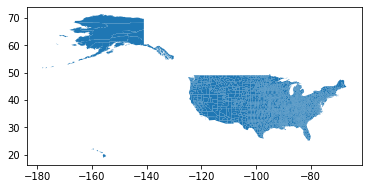

In [14]:
counties.plot()

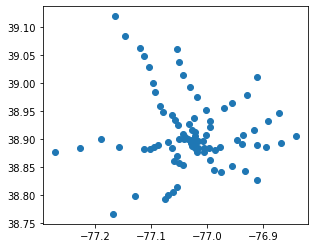

In [15]:
stations.plot()

In [16]:
counties.head()

,name,state_name,state_fips,cnty_fips,fips,geometry
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715..."
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4..."
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0..."
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9..."
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9..."


In [18]:
stations.head()

,name,marker-col,marker-sym,line,geometry
0,Van Dorn Street,#0000ff,rail-metro,blue,POINT (-77.12911 38.79931)
1,Franconia-Springfield,#0000ff,rail-metro,blue,POINT (-77.16797 38.76652)
2,Federal Center SW,#0000ff,rail-metro,blue,POINT (-77.01587 38.88507)
3,Judiciary Sq,#ff0000,rail-metro,red,POINT (-77.01664 38.89609)
4,Capitol South,#0000ff,rail-metro,blue,POINT (-77.00514 38.88506)


In [0]:
stations.to_csv('stations.csv')

In [0]:
counties.to_csv('counties.csv')

In [0]:
counties = spark.read.option("delimiter", ",").option("header", "true").csv("counties.csv")

In [22]:
counties.take(5)

[Row(_c0='0', name='Lake of the Woods', state_name='Minnesota', state_fips='27', cnty_fips='077', fips='27077', geometry='POLYGON ((-95.34283127277658 48.546679319076, -95.34105289190684 48.71517195733587, -95.09435905148669 48.71735751795556, -95.09491035007436 48.91176243313237, -95.13382124476209 48.89448474990026, -95.21957848050616 48.87944650348885, -95.29026017093044 48.90294958174785, -95.31417172404038 48.93207199957641, -95.30375729897271 48.94593890485217, -95.32091645456259 48.96097699585145, -95.32323587682019 48.97895631299366, -95.31012059635258 48.993395445689, -95.27665710362751 48.99999118779381, -95.15774989320504 48.9999959019614, -95.15186733731112 49.37173013664074, -94.83203924782775 49.33080592976444, -94.68124996659202 48.87716132370133, -94.69443202246646 48.77761551038913, -94.57031275583246 48.71367627110933, -94.43063445677862 48.71078529488466, -94.43169006769017 48.36821243467153, -95.21178803364391 48.36900472565064, -95.21983978008106 48.54435777285279,

In [0]:
counties.createOrReplaceTempView("county")

In [0]:
counties_geom = spark.sql(
      "SELECT name, st_geomFromWKT(geometry) as geometry from county"
)

In [25]:
counties_geom.show(5, False)

+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
stations_geom = spark.createDataFrame(
    stations[["name", "geometry"]]
)

In [27]:
stations_geom.show(5, False)

+---------------------+---------------------------------------------+
|name                 |geometry                                     |
+---------------------+---------------------------------------------+
|Van Dorn Street      |POINT (-77.12911152370515 38.79930767201779) |
|Franconia-Springfield|POINT (-77.16797018042666 38.766521892689916)|
|Federal Center SW    |POINT (-77.01586821694521 38.885072355144786)|
|Judiciary Sq         |POINT (-77.01663895662587 38.896090317663166)|
|Capitol South        |POINT (-77.00513941992737 38.885062500925)   |
+---------------------+---------------------------------------------+
only showing top 5 rows



In [0]:
stations_geom.createOrReplaceTempView("stations")
counties_geom.createOrReplaceTempView("counties")

In [0]:
spatial_join_result = spark.sql(
    """
        SELECT c.name, s.name
        FROM stations AS s, counties AS c
        WHERE ST_Intersects(s.geometry, c.geometry)
    """
)

In [30]:
spatial_join_result.explain()

== Physical Plan ==
*(2) Project [name#27, name#59]
+- RangeJoin geometry#60: geometry, geometry#47: geometry, true
   :- Scan ExistingRDD[name#59,geometry#60]
   +- Project [name#27, st_geomfromwkt(geometry#32) AS geometry#47]
      +- *(1) FileScan csv [name#27,geometry#32] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/content/counties.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<name:string,geometry:string>


In [0]:
stations_per_county = spatial_join_result.groupBy("c.name").count()

In [38]:
stations_per_county.show(50, False)

+--------------------+-----+
|name                |count|
+--------------------+-----+
|Prince George's     |14   |
|Alexandria          |3    |
|Montgomery          |12   |
|District of Columbia|42   |
|Arlington           |9    |
|Fairfax             |6    |
+--------------------+-----+

